# Airbnb Case Study

In [1]:
# Magic Commands
%matplotlib inline

# Third-Party Packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
# Pandas Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

## Data Import and First Preview

In [3]:
# Import the data set
airbnb_first_bookings = pd.read_csv('https://raw.githubusercontent.com/saschaschworm/dsb/master/Data%20Sets/Demos%20and%20Exercises/airbnb_bookings/airbnb_bookings.csv')

In [4]:
# Display the first 5 rows of the data set
airbnb_first_bookings.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,nan,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0000,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0000,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0000,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0000,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [5]:
# Display the data types
pd.DataFrame(airbnb_first_bookings.dtypes).T

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,object,object,int64,object,object,float64,object,int64,object,object,object,object,object,object,object,object


In [6]:
# Display the data set dimensionality
airbnb_first_bookings.shape

(213451, 16)

In [7]:
# Display summary statistics for features with object data type 
airbnb_first_bookings.select_dtypes(['object', 'bool']).describe()

,id,date_account_created,date_first_booking,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,213451,213451,88908,213451,213451,213451,213451,213451,207386,213451,213451,213451,213451
unique,213451,1634,1976,4,3,25,8,18,7,4,9,52,12
top,vu7anpzkpx,2014-05-13,2014-05-22,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,1,674,248,95688,152897,206314,137727,137426,109232,182717,89600,63845,124543


In [8]:
# Display summary statistics for features with numeric data type 
airbnb_first_bookings.select_dtypes(['float64', 'int64']).describe()

,timestamp_first_active,age,signup_flow
count,213451.0000,125461.0000,213451.0000
mean,20130850417367.2578,49.6683,3.2674
std,9253717046.5838,155.6666,7.6377
min,20090319043255.0000,1.0000,0.0000
25%,20121225073327.5000,28.0000,0.0000
50%,20130911061308.0000,34.0000,0.0000
75%,20140306082494.0000,43.0000,0.0000
max,20140630235824.0000,2014.0000,25.0000


## Data Preprocessing I

In [9]:
# Make a copy of the actual data set for further reference if neccessary
data_preprocessed = airbnb_first_bookings.copy()

### Data Type Transformations

In [10]:
# Transform date features to actual date data types
data_preprocessed['date_account_created'] = pd.to_datetime(data_preprocessed['date_account_created'], format='%Y-%m-%d')
data_preprocessed['timestamp_first_active'] = pd.to_datetime(data_preprocessed['timestamp_first_active'], format='%Y%m%d%H%M%S')
data_preprocessed['date_first_booking'] = pd.to_datetime(data_preprocessed['date_first_booking'], format='%Y-%m-%d')

In [11]:
# Create a date-only feature of the "timestamp_first_active" feature
data_preprocessed['date_first_active'] = data_preprocessed['timestamp_first_active'].dt.normalize()

In [12]:
# Transform the "signup_flow" feature to an actual categorical Feature
data_preprocessed['signup_flow'] = data_preprocessed['signup_flow'].astype('object')

In [13]:
# Display the data types
pd.DataFrame(data_preprocessed.dtypes).T

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,date_first_active
0,object,datetime64[ns],datetime64[ns],datetime64[ns],object,float64,object,object,object,object,object,object,object,object,object,object,datetime64[ns]


### Feature Engineering

In [14]:
# Extract weekdays from date features
data_preprocessed['dac_day'] = data_preprocessed['date_account_created'].dt.day
data_preprocessed['dfa_day'] = data_preprocessed['date_first_active'].dt.day
data_preprocessed['dfb_day'] = data_preprocessed['date_first_booking'].dt.day

In [15]:
# Extract weekdays from date features
data_preprocessed['dac_weekday'] = data_preprocessed['date_account_created'].dt.weekday_name
data_preprocessed['dfa_weekday'] = data_preprocessed['date_first_active'].dt.weekday_name
data_preprocessed['dfb_weekday'] = data_preprocessed['date_first_booking'].dt.weekday_name

In [16]:
# Extract months from date features
data_preprocessed['dac_month'] = data_preprocessed['date_account_created'].dt.month_name()
data_preprocessed['dfc_month'] = data_preprocessed['date_first_active'].dt.month_name()
data_preprocessed['dfb_month'] = data_preprocessed['date_first_booking'].dt.month_name()

In [17]:
# Compute time deltas from date features
data_preprocessed['dac_dfc_delta'] = np.abs((data_preprocessed['date_first_active'] - data_preprocessed['date_account_created']).dt.days)
data_preprocessed['dac_dfb_delta'] = np.abs((data_preprocessed['date_first_booking'] - data_preprocessed['date_account_created']).dt.days)
data_preprocessed['dfa_dfb_delta'] = np.abs((data_preprocessed['date_first_booking'] - data_preprocessed['date_first_active']).dt.days)
data_preprocessed['dfa_before_dac'] = np.where((data_preprocessed['date_first_active'] - data_preprocessed['date_account_created']).dt.days < 0, True, False)

In [18]:
# Create features indicating holidays in the next 30 days
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=data_preprocessed['date_first_active'].min(), end=data_preprocessed['date_account_created'].max())

holiday_cal = pd.DataFrame({'date':pd.date_range(data_preprocessed['date_first_active'].min(), data_preprocessed['date_account_created'].max())})
holiday_cal['holiday'] = holiday_cal['date'].isin(holidays).replace(False, np.NaN).bfill(limit=30).fillna(0).astype(bool)

data_preprocessed['dac_holiday'] = pd.merge(data_preprocessed, holiday_cal, how='left', left_on='date_account_created', right_on='date')['holiday']
data_preprocessed['dfa_holiday'] = pd.merge(data_preprocessed, holiday_cal, how='left', left_on='date_first_active', right_on='date')['holiday']

In [19]:
# Display the first 5 rows of the data set
data_preprocessed.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,date_first_active,dac_day,dfa_day,dfb_day,dac_weekday,dfa_weekday,dfb_weekday,dac_month,dfc_month,dfb_month,dac_dfc_delta,dac_dfb_delta,dfa_dfb_delta,dfa_before_dac,dac_holiday,dfa_holiday
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,nan,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,2009-03-19,28,19,nan,Monday,Thursday,NaN,June,March,NaN,466,nan,nan,True,True,False
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0000,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,2009-05-23,25,23,nan,Wednesday,Saturday,NaN,May,May,NaN,732,nan,nan,True,True,True
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0000,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2009-06-09,28,9,2.0000,Tuesday,Tuesday,Monday,September,June,August,476,57.0000,419.0000,True,True,True
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0000,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2009-10-31,5,31,8.0000,Monday,Saturday,Saturday,December,October,September,765,278.0000,1043.0000,True,True,True
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0000,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,2009-12-08,14,8,18.0000,Tuesday,Tuesday,Thursday,September,December,February,280,208.0000,72.0000,True,True,True


### Feature Transformation

In [20]:
# Restrict the "age" feature to be in range [15, 100]
data_preprocessed['age'] = np.where(np.logical_or(data_preprocessed['age'] < 14, data_preprocessed['age'] > 100), np.NaN, data_preprocessed['age'])

In [21]:
# Set missing values in the "age" feature to a machine-readable number still indicating missingness
data_preprocessed['age_nafill'] = data_preprocessed['age'].fillna(-1)

In [22]:
# Impute mmissing age values and create a new feature indicating that an imputed value has originally been missing
median_imputer, missing_indicator = SimpleImputer(missing_values=np.NaN, strategy='median'), MissingIndicator(missing_values=np.NaN)
data_preprocessed['age_imputed'] = median_imputer.fit_transform(data_preprocessed[['age']])
data_preprocessed['age_missing'] = missing_indicator.fit_transform(data_preprocessed[['age']])

In [23]:
# Fill empty values in categorical "first_affiliate_tracked" feature 
data_preprocessed['first_affiliate_tracked'].fillna('unknown', inplace=True)

In [24]:
# Display the first 5 rows of the data set
data_preprocessed.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,date_first_active,dac_day,dfa_day,dfb_day,dac_weekday,dfa_weekday,dfb_weekday,dac_month,dfc_month,dfb_month,dac_dfc_delta,dac_dfb_delta,dfa_dfb_delta,dfa_before_dac,dac_holiday,dfa_holiday,age_nafill,age_imputed,age_missing
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,nan,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,2009-03-19,28,19,nan,Monday,Thursday,NaN,June,March,NaN,466,nan,nan,True,True,False,-1.0000,34.0000,True
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0000,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,2009-05-23,25,23,nan,Wednesday,Saturday,NaN,May,May,NaN,732,nan,nan,True,True,True,38.0000,38.0000,False
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0000,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2009-06-09,28,9,2.0000,Tuesday,Tuesday,Monday,September,June,August,476,57.0000,419.0000,True,True,True,56.0000,56.0000,False
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0000,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2009-10-31,5,31,8.0000,Monday,Saturday,Saturday,December,October,September,765,278.0000,1043.0000,True,True,True,42.0000,42.0000,False
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0000,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,2009-12-08,14,8,18.0000,Tuesday,Tuesday,Thursday,September,December,February,280,208.0000,72.0000,True,True,True,41.0000,41.0000,False


#### Categorical Encoding

##### Label Encoding

In [25]:
le_feature_names = []
for categorical_feature in list(data_preprocessed.select_dtypes(['object', 'bool']).drop(['id', 'dfb_weekday', 'dfb_month'], axis=1).columns):
    label_encoder = LabelEncoder()
    feature_name = f'le_{categorical_feature}'
    data_preprocessed[feature_name] = label_encoder.fit_transform(data_preprocessed[categorical_feature])
    le_feature_names.append(feature_name)

In [26]:
# Display the first 5 rows of the data set
data_preprocessed.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,date_first_active,dac_day,dfa_day,dfb_day,dac_weekday,dfa_weekday,dfb_weekday,dac_month,dfc_month,dfb_month,dac_dfc_delta,dac_dfb_delta,dfa_dfb_delta,dfa_before_dac,dac_holiday,dfa_holiday,age_nafill,age_imputed,age_missing,le_gender,le_signup_method,le_signup_flow,le_language,le_affiliate_channel,le_affiliate_provider,le_first_affiliate_tracked,le_signup_app,le_first_device_type,le_first_browser,le_country_destination,le_dac_weekday,le_dfa_weekday,le_dac_month,le_dfc_month,le_dfa_before_dac,le_dac_holiday,le_dfa_holiday,le_age_missing
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,nan,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,2009-03-19,28,19,nan,Monday,Thursday,NaN,June,March,NaN,466,nan,nan,True,True,False,-1.0000,34.0000,True,0,1,0,5,2,4,7,2,3,8,7,1,4,6,7,1,1,0,1
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0000,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,2009-05-23,25,23,nan,Wednesday,Saturday,NaN,May,May,NaN,732,nan,nan,True,True,True,38.0000,38.0000,False,2,1,0,5,7,8,7,2,3,8,7,6,2,8,8,1,1,1,0
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0000,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2009-06-09,28,9,2.0000,Tuesday,Tuesday,Monday,September,June,August,476,57.0000,419.0000,True,True,True,56.0000,56.0000,False,1,0,3,5,2,4,7,2,6,21,10,5,5,11,6,1,1,1,0
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0000,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2009-10-31,5,31,8.0000,Monday,Saturday,Saturday,December,October,September,765,278.0000,1043.0000,True,True,True,42.0000,42.0000,False,1,1,0,5,2,4,7,2,3,17,11,1,2,2,10,1,1,1,0
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0000,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,2009-12-08,14,8,18.0000,Tuesday,Tuesday,Thursday,September,December,February,280,208.0000,72.0000,True,True,True,41.0000,41.0000,False,0,0,0,5,2,4,7,2,3,8,10,5,5,11,2,1,1,1,0


##### One-Hot-Encoding

In [27]:
ohe_feature_names = []
for categorical_feature in list(data_preprocessed.select_dtypes(['object', 'bool']).drop(['id', 'dfb_weekday', 'dfb_month', 'country_destination'], axis=1).columns):
    df_dummies = pd.get_dummies(data_preprocessed[categorical_feature], prefix=categorical_feature)
    data_preprocessed = pd.concat((data_preprocessed, df_dummies), axis=1)
    ohe_feature_names = ohe_feature_names + list(df_dummies.columns)

In [28]:
# Display the first 5 rows of the data set
data_preprocessed.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,date_first_active,dac_day,dfa_day,dfb_day,dac_weekday,dfa_weekday,dfb_weekday,dac_month,dfc_month,dfb_month,dac_dfc_delta,dac_dfb_delta,dfa_dfb_delta,dfa_before_dac,dac_holiday,dfa_holiday,age_nafill,age_imputed,age_missing,le_gender,le_signup_method,le_signup_flow,le_language,le_affiliate_channel,le_affiliate_provider,le_first_affiliate_tracked,le_signup_app,le_first_device_type,le_first_browser,le_country_destination,le_dac_weekday,le_dfa_weekday,le_dac_month,le_dfc_month,le_dfa_before_dac,le_dac_holiday,le_dfa_holiday,le_age_missing,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,signup_flow_0,signup_flow_1,signup_flow_2,signup_flow_3,signup_flow_4,signup_flow_5,signup_flow_6,signup_flow_8,signup_flow_10,signup_flow_12,signup_flow_15,signup_flow_16,signup_flow_20,signup_flow_21,signup_flow_23,signup_flow_24,signup_flow_25,language_ca,language_cs,language_da,language_de,language_el,language_en,language_es,language_fi,language_fr,language_hr,language_hu,language_id,language_is,language_it,language_ja,language_ko,language_nl,language_no,language_pl,language_pt,language_ru,language_sv,language_th,language_tr,language_zh,affiliate_channel_api,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,affiliate_provider_baidu,affiliate_provider_bing,affiliate_provider_craigslist,affiliate_provider_daum,affiliate_provider_direct,affiliate_provider_email-marketing,affiliate_provider_facebook,affiliate_provider_facebook-open-graph,affiliate_provider_google,affiliate_provider_gsp,affiliate_provider_meetup,affiliate_provider_naver,affiliate_provider_other,affiliate_provider_padmapper,affiliate_provider_vast,affiliate_provider_wayn,affiliate_provider_yahoo,affiliate_provider_yandex,first_affiliate_tracked_linked,first_affiliate_tracked_local ops,first_affiliate_tracked_marketing,first_affiliate_tracked_omg,first_affiliate_tracked_product,first_affiliate_tracked_tracked-other,first_affiliate_tracked_unknown,first_affiliate_tracked_untracked,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,first_device_type_Android Phone,first_device_type_Android Tablet,first_device_type_Desktop (Other),first_device_type_Mac Desktop,first_device_type_Other/Unknown,first_device_type_SmartPhone (Other),first_device_type_Windows Desktop,first_device_type_iPad,first_device_type_iPhone,first_browser_-unknown-,first_browser_AOL Explorer,first_browser_Android Browser,first_browser_Apple Mail,first_browser_Arora,first_browser_Avant Browser,first_browser_BlackBerry Browser,first_browser_Camino,first_browser_Chrome,first_browser_Chrome Mobile,first_browser_Chromium,first_browser_CometBird,first_browser_Comodo Dragon,first_browser_Conkeror,first_browser_CoolNovo,first_browser_Crazy Browser,first_browser_Epic,first_browser_Firefox,first_browser_Flock,first_browser_Google Earth,first_browser_Googlebot,first_browser_IE,first_browser_IE Mobile,first_browser_IceDragon,first_browser_IceWeasel,first_browser_Iron,first_browser_Kindle Browser,first_browser_Maxthon,first_browser_Mobile Firefox,first_browser_Mobile Safari,first_browser_Mozilla,first_browser_NetNewsWire,first_browser_OmniWeb,first_browser_Opera,first_browser_Opera Mini,first_browser_Opera Mobile,first_browser_Outlook 2007,first_browser_PS Vita browser,first_browser_Pale Moon,first_browser_Palm Pre web browser,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_

#### Normalization

##### Standard Scaling

In [29]:
normalized_numerical_feature_names = []
for numeric_feature in list(data_preprocessed.select_dtypes(['int64', 'float64']).drop(['age', 'dfb_day', 'dac_dfb_delta', 'dfa_dfb_delta'], axis=1).columns[0:5]):
    scaler = StandardScaler()
    feature_name = f'norm_{numeric_feature}'
    data_preprocessed[feature_name] = scaler.fit_transform(data_preprocessed[[numeric_feature]].values)
    normalized_numerical_feature_names.append(feature_name)

/Users/sascha/.local/share/virtualenvs/Introduction_to_Data_Science-n_NsBj_h/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/sascha/.local/share/virtualenvs/Introduction_to_Data_Science-n_NsBj_h/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/sascha/.local/share/virtualenvs/Introduction_to_Data_Science-n_NsBj_h/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/sascha/.local/share/virtualenvs/Introduction_to_Data_Science-n_NsBj_h/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data wit

In [30]:
# Display the first 5 rows of the data set
data_preprocessed.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,date_first_active,dac_day,dfa_day,dfb_day,dac_weekday,dfa_weekday,dfb_weekday,dac_month,dfc_month,dfb_month,dac_dfc_delta,dac_dfb_delta,dfa_dfb_delta,dfa_before_dac,dac_holiday,dfa_holiday,age_nafill,age_imputed,age_missing,le_gender,le_signup_method,le_signup_flow,le_language,le_affiliate_channel,le_affiliate_provider,le_first_affiliate_tracked,le_signup_app,le_first_device_type,le_first_browser,le_country_destination,le_dac_weekday,le_dfa_weekday,le_dac_month,le_dfc_month,le_dfa_before_dac,le_dac_holiday,le_dfa_holiday,le_age_missing,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,signup_flow_0,signup_flow_1,signup_flow_2,signup_flow_3,signup_flow_4,signup_flow_5,signup_flow_6,signup_flow_8,signup_flow_10,signup_flow_12,signup_flow_15,signup_flow_16,signup_flow_20,signup_flow_21,signup_flow_23,signup_flow_24,signup_flow_25,language_ca,language_cs,language_da,language_de,language_el,language_en,language_es,language_fi,language_fr,language_hr,language_hu,language_id,language_is,language_it,language_ja,language_ko,language_nl,language_no,language_pl,language_pt,language_ru,language_sv,language_th,language_tr,language_zh,affiliate_channel_api,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,affiliate_provider_baidu,affiliate_provider_bing,affiliate_provider_craigslist,affiliate_provider_daum,affiliate_provider_direct,affiliate_provider_email-marketing,affiliate_provider_facebook,affiliate_provider_facebook-open-graph,affiliate_provider_google,affiliate_provider_gsp,affiliate_provider_meetup,affiliate_provider_naver,affiliate_provider_other,affiliate_provider_padmapper,affiliate_provider_vast,affiliate_provider_wayn,affiliate_provider_yahoo,affiliate_provider_yandex,first_affiliate_tracked_linked,first_affiliate_tracked_local ops,first_affiliate_tracked_marketing,first_affiliate_tracked_omg,first_affiliate_tracked_product,first_affiliate_tracked_tracked-other,first_affiliate_tracked_unknown,first_affiliate_tracked_untracked,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,first_device_type_Android Phone,first_device_type_Android Tablet,first_device_type_Desktop (Other),first_device_type_Mac Desktop,first_device_type_Other/Unknown,first_device_type_SmartPhone (Other),first_device_type_Windows Desktop,first_device_type_iPad,first_device_type_iPhone,first_browser_-unknown-,first_browser_AOL Explorer,first_browser_Android Browser,first_browser_Apple Mail,first_browser_Arora,first_browser_Avant Browser,first_browser_BlackBerry Browser,first_browser_Camino,first_browser_Chrome,first_browser_Chrome Mobile,first_browser_Chromium,first_browser_CometBird,first_browser_Comodo Dragon,first_browser_Conkeror,first_browser_CoolNovo,first_browser_Crazy Browser,first_browser_Epic,first_browser_Firefox,first_browser_Flock,first_browser_Google Earth,first_browser_Googlebot,first_browser_IE,first_browser_IE Mobile,first_browser_IceDragon,first_browser_IceWeasel,first_browser_Iron,first_browser_Kindle Browser,first_browser_Maxthon,first_browser_Mobile Firefox,first_browser_Mobile Safari,first_browser_Mozilla,first_browser_NetNewsWire,first_browser_OmniWeb,first_browser_Opera,first_browser_Opera Mini,first_browser_Opera Mobile,first_browser_Outlook 2007,first_browser_PS Vita browser,first_browser_Pale Moon,first_browser_Palm Pre web browser,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_

## Summary Statistics

In [31]:
# Display the First 5 Rows
data_preprocessed.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,date_first_active,dac_day,dfa_day,dfb_day,dac_weekday,dfa_weekday,dfb_weekday,dac_month,dfc_month,dfb_month,dac_dfc_delta,dac_dfb_delta,dfa_dfb_delta,dfa_before_dac,dac_holiday,dfa_holiday,age_nafill,age_imputed,age_missing,le_gender,le_signup_method,le_signup_flow,le_language,le_affiliate_channel,le_affiliate_provider,le_first_affiliate_tracked,le_signup_app,le_first_device_type,le_first_browser,le_country_destination,le_dac_weekday,le_dfa_weekday,le_dac_month,le_dfc_month,le_dfa_before_dac,le_dac_holiday,le_dfa_holiday,le_age_missing,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,signup_flow_0,signup_flow_1,signup_flow_2,signup_flow_3,signup_flow_4,signup_flow_5,signup_flow_6,signup_flow_8,signup_flow_10,signup_flow_12,signup_flow_15,signup_flow_16,signup_flow_20,signup_flow_21,signup_flow_23,signup_flow_24,signup_flow_25,language_ca,language_cs,language_da,language_de,language_el,language_en,language_es,language_fi,language_fr,language_hr,language_hu,language_id,language_is,language_it,language_ja,language_ko,language_nl,language_no,language_pl,language_pt,language_ru,language_sv,language_th,language_tr,language_zh,affiliate_channel_api,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,affiliate_provider_baidu,affiliate_provider_bing,affiliate_provider_craigslist,affiliate_provider_daum,affiliate_provider_direct,affiliate_provider_email-marketing,affiliate_provider_facebook,affiliate_provider_facebook-open-graph,affiliate_provider_google,affiliate_provider_gsp,affiliate_provider_meetup,affiliate_provider_naver,affiliate_provider_other,affiliate_provider_padmapper,affiliate_provider_vast,affiliate_provider_wayn,affiliate_provider_yahoo,affiliate_provider_yandex,first_affiliate_tracked_linked,first_affiliate_tracked_local ops,first_affiliate_tracked_marketing,first_affiliate_tracked_omg,first_affiliate_tracked_product,first_affiliate_tracked_tracked-other,first_affiliate_tracked_unknown,first_affiliate_tracked_untracked,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,first_device_type_Android Phone,first_device_type_Android Tablet,first_device_type_Desktop (Other),first_device_type_Mac Desktop,first_device_type_Other/Unknown,first_device_type_SmartPhone (Other),first_device_type_Windows Desktop,first_device_type_iPad,first_device_type_iPhone,first_browser_-unknown-,first_browser_AOL Explorer,first_browser_Android Browser,first_browser_Apple Mail,first_browser_Arora,first_browser_Avant Browser,first_browser_BlackBerry Browser,first_browser_Camino,first_browser_Chrome,first_browser_Chrome Mobile,first_browser_Chromium,first_browser_CometBird,first_browser_Comodo Dragon,first_browser_Conkeror,first_browser_CoolNovo,first_browser_Crazy Browser,first_browser_Epic,first_browser_Firefox,first_browser_Flock,first_browser_Google Earth,first_browser_Googlebot,first_browser_IE,first_browser_IE Mobile,first_browser_IceDragon,first_browser_IceWeasel,first_browser_Iron,first_browser_Kindle Browser,first_browser_Maxthon,first_browser_Mobile Firefox,first_browser_Mobile Safari,first_browser_Mozilla,first_browser_NetNewsWire,first_browser_OmniWeb,first_browser_Opera,first_browser_Opera Mini,first_browser_Opera Mobile,first_browser_Outlook 2007,first_browser_PS Vita browser,first_browser_Pale Moon,first_browser_Palm Pre web browser,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_

In [32]:
# Display the Data Type for Each Column
pd.DataFrame(data_preprocessed.dtypes).T

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,date_first_active,dac_day,dfa_day,dfb_day,dac_weekday,dfa_weekday,dfb_weekday,dac_month,dfc_month,dfb_month,dac_dfc_delta,dac_dfb_delta,dfa_dfb_delta,dfa_before_dac,dac_holiday,dfa_holiday,age_nafill,age_imputed,age_missing,le_gender,le_signup_method,le_signup_flow,le_language,le_affiliate_channel,le_affiliate_provider,le_first_affiliate_tracked,le_signup_app,le_first_device_type,le_first_browser,le_country_destination,le_dac_weekday,le_dfa_weekday,le_dac_month,le_dfc_month,le_dfa_before_dac,le_dac_holiday,le_dfa_holiday,le_age_missing,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,signup_flow_0,signup_flow_1,signup_flow_2,signup_flow_3,signup_flow_4,signup_flow_5,signup_flow_6,signup_flow_8,signup_flow_10,signup_flow_12,signup_flow_15,signup_flow_16,signup_flow_20,signup_flow_21,signup_flow_23,signup_flow_24,signup_flow_25,language_ca,language_cs,language_da,language_de,language_el,language_en,language_es,language_fi,language_fr,language_hr,language_hu,language_id,language_is,language_it,language_ja,language_ko,language_nl,language_no,language_pl,language_pt,language_ru,language_sv,language_th,language_tr,language_zh,affiliate_channel_api,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,affiliate_provider_baidu,affiliate_provider_bing,affiliate_provider_craigslist,affiliate_provider_daum,affiliate_provider_direct,affiliate_provider_email-marketing,affiliate_provider_facebook,affiliate_provider_facebook-open-graph,affiliate_provider_google,affiliate_provider_gsp,affiliate_provider_meetup,affiliate_provider_naver,affiliate_provider_other,affiliate_provider_padmapper,affiliate_provider_vast,affiliate_provider_wayn,affiliate_provider_yahoo,affiliate_provider_yandex,first_affiliate_tracked_linked,first_affiliate_tracked_local ops,first_affiliate_tracked_marketing,first_affiliate_tracked_omg,first_affiliate_tracked_product,first_affiliate_tracked_tracked-other,first_affiliate_tracked_unknown,first_affiliate_tracked_untracked,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,first_device_type_Android Phone,first_device_type_Android Tablet,first_device_type_Desktop (Other),first_device_type_Mac Desktop,first_device_type_Other/Unknown,first_device_type_SmartPhone (Other),first_device_type_Windows Desktop,first_device_type_iPad,first_device_type_iPhone,first_browser_-unknown-,first_browser_AOL Explorer,first_browser_Android Browser,first_browser_Apple Mail,first_browser_Arora,first_browser_Avant Browser,first_browser_BlackBerry Browser,first_browser_Camino,first_browser_Chrome,first_browser_Chrome Mobile,first_browser_Chromium,first_browser_CometBird,first_browser_Comodo Dragon,first_browser_Conkeror,first_browser_CoolNovo,first_browser_Crazy Browser,first_browser_Epic,first_browser_Firefox,first_browser_Flock,first_browser_Google Earth,first_browser_Googlebot,first_browser_IE,first_browser_IE Mobile,first_browser_IceDragon,first_browser_IceWeasel,first_browser_Iron,first_browser_Kindle Browser,first_browser_Maxthon,first_browser_Mobile Firefox,first_browser_Mobile Safari,first_browser_Mozilla,first_browser_NetNewsWire,first_browser_OmniWeb,first_browser_Opera,first_browser_Opera Mini,first_browser_Opera Mobile,first_browser_Outlook 2007,first_browser_PS Vita browser,first_browser_Pale Moon,first_browser_Palm Pre web browser,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_

In [33]:
# Summary Statistics of Features with Object Data Type 
data_preprocessed.select_dtypes(['object', 'bool']).describe().T

,count,unique,top,freq
id,213451,213451,vu7anpzkpx,1
gender,213451,4,-unknown-,95688
signup_method,213451,3,basic,152897
signup_flow,213451,17,0,164739
language,213451,25,en,206314
affiliate_channel,213451,8,direct,137727
affiliate_provider,213451,18,direct,137426
first_affiliate_tracked,213451,8,untracked,109232
signup_app,213451,4,Web,182717
first_device_type,213451,9,Mac Desktop,89600


In [34]:
# Summary Statistics of Features with Numeric Data Type
data_preprocessed.select_dtypes(['float64', 'int64']).describe().T

,count,mean,std,min,25%,50%,75%,max
age,123059.0000,36.5592,11.6906,15.0000,28.0000,34.0000,42.0000,100.0000
dac_day,213451.0000,15.8692,8.7401,1.0000,8.0000,16.0000,23.0000,31.0000
dfa_day,213451.0000,15.8691,8.7396,1.0000,8.0000,16.0000,23.0000,31.0000
dfb_day,88908.0000,15.6445,8.7256,1.0000,8.0000,16.0000,23.0000,31.0000
dac_dfc_delta,213451.0000,0.2318,11.9484,0.0000,0.0000,0.0000,0.0000,1456.0000
dac_dfb_delta,88908.0000,44.4468,87.4568,0.0000,1.0000,3.0000,29.0000,365.0000
dfa_dfb_delta,88908.0000,44.6922,88.4828,0.0000,1.0000,3.0000,29.0000,1369.0000
age_nafill,213451.0000,20.6537,20.5720,-1.0000,-1.0000,26.0000,35.0000,100.0000
age_imputed,213451.0000,35.4754,8.9662,15.0000,32.0000,34.0000,35.0000,100.0000
le_gender,213451.0000,0.8094,0.8199,0.0000,0.0000,1.0000,2.0000,3.0000


In [35]:
# Summary Statistics of Features with Date Data Type
data_preprocessed.select_dtypes(['datetime64[ns]']).describe().T

,count,unique,top,freq,first,last
date_account_created,213451,1634,2014-05-13 00:00:00,674,2010-01-01 00:00:00,2014-06-30 00:00:00
timestamp_first_active,213451,213451,2013-07-01 05:26:34,1,2009-03-19 04:32:55,2014-06-30 23:58:24
date_first_booking,88908,1976,2014-05-22 00:00:00,248,2010-01-02 00:00:00,2015-06-29 00:00:00
date_first_active,213451,1639,2014-05-13 00:00:00,673,2009-03-19 00:00:00,2014-06-30 00:00:00


## Visualizations

### Categorical Features

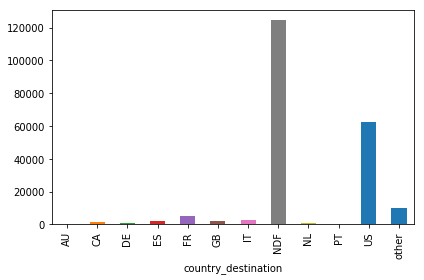

In [36]:
fig, ax = plt.subplots(figsize=(6, 4))

data_preprocessed.groupby('country_destination').size().plot(kind='bar', ax=ax)

plt.tight_layout()
plt.show()

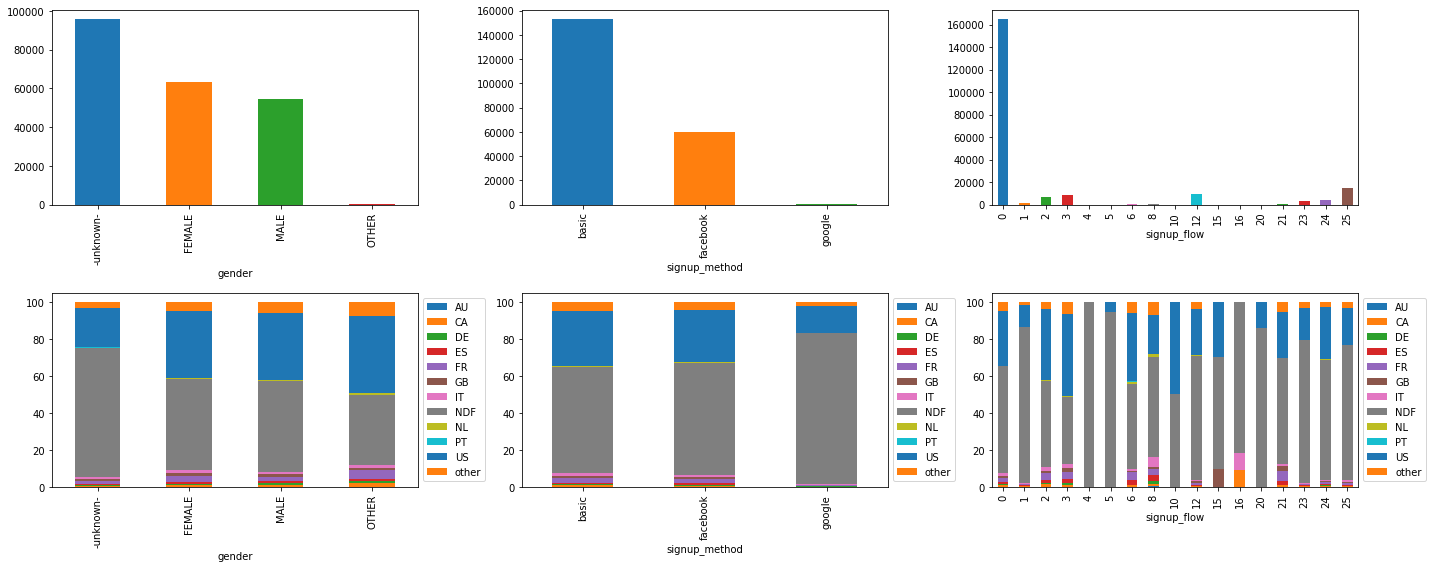

In [37]:
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(231)
data_preprocessed.groupby('gender').size().plot(kind='bar', ax=ax1)

ax2 = fig.add_subplot(232)
data_preprocessed.groupby('signup_method').size().plot(kind='bar', ax=ax2)

ax3 = fig.add_subplot(233)
data_preprocessed.groupby('signup_flow').size().plot(kind='bar', ax=ax3)

ax4 = fig.add_subplot(234)
data_preprocessed.groupby(['gender', 'country_destination']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax4)
ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax5 = fig.add_subplot(235)
data_preprocessed.groupby(['signup_method', 'country_destination']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax5)
ax5.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax6 = fig.add_subplot(236)
data_preprocessed.groupby(['signup_flow', 'country_destination']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax6)
ax6.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

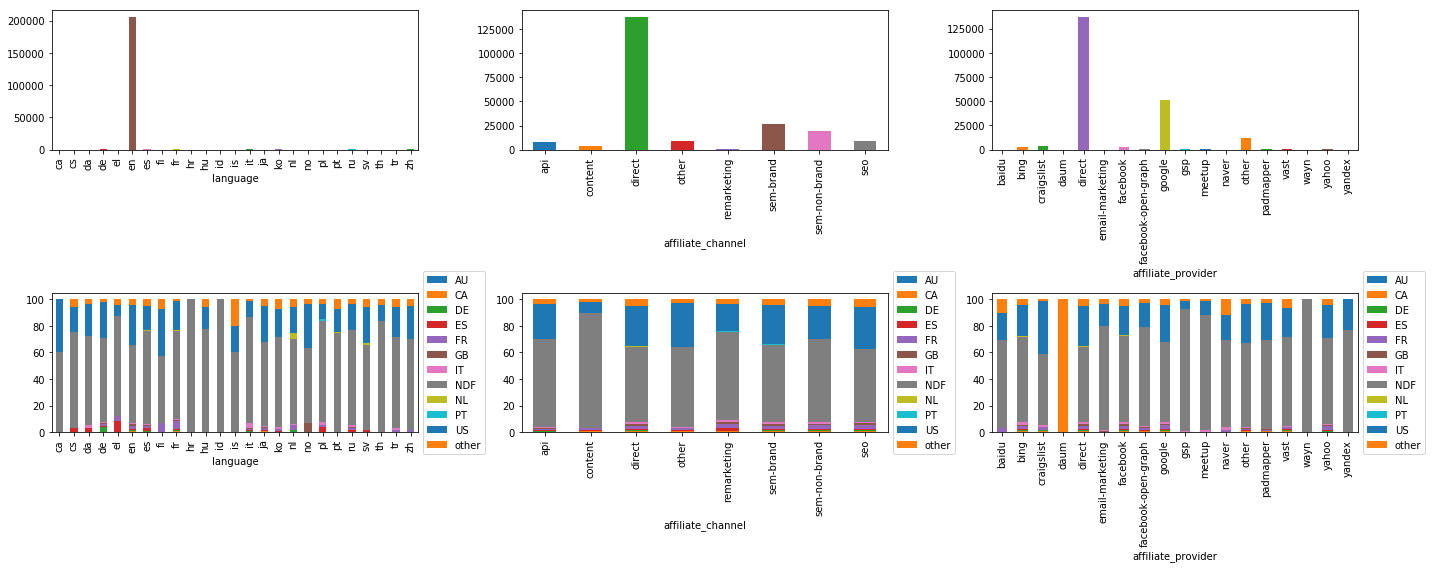

In [38]:
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(231)
data_preprocessed.groupby('language').size().plot(kind='bar', ax=ax1)

ax2 = fig.add_subplot(232)
data_preprocessed.groupby('affiliate_channel').size().plot(kind='bar', ax=ax2)

ax3 = fig.add_subplot(233)
data_preprocessed.groupby('affiliate_provider').size().plot(kind='bar', ax=ax3)

ax4 = fig.add_subplot(234)
data_preprocessed.groupby(['language', 'country_destination']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax4)
ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax5 = fig.add_subplot(235)
data_preprocessed.groupby(['affiliate_channel', 'country_destination']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax5)
ax5.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax6 = fig.add_subplot(236)
data_preprocessed.groupby(['affiliate_provider', 'country_destination']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax6)
ax6.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

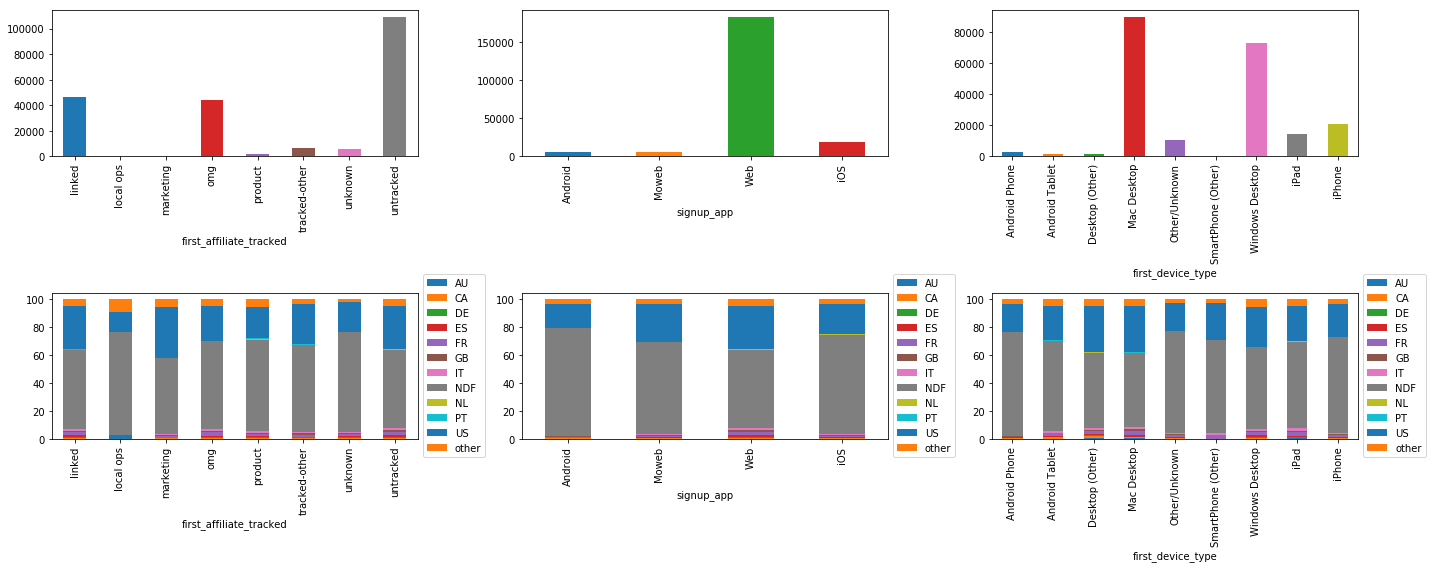

In [39]:
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(231)
data_preprocessed.groupby('first_affiliate_tracked').size().plot(kind='bar', ax=ax1)

ax2 = fig.add_subplot(232)
data_preprocessed.groupby('signup_app').size().plot(kind='bar', ax=ax2)

ax3 = fig.add_subplot(233)
data_preprocessed.groupby('first_device_type').size().plot(kind='bar', ax=ax3)

ax4 = fig.add_subplot(234)
data_preprocessed.groupby(['first_affiliate_tracked', 'country_destination']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax4)
ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax5 = fig.add_subplot(235)
data_preprocessed.groupby(['signup_app', 'country_destination']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax5)
ax5.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax6 = fig.add_subplot(236)
data_preprocessed.groupby(['first_device_type', 'country_destination']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax6)
ax6.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

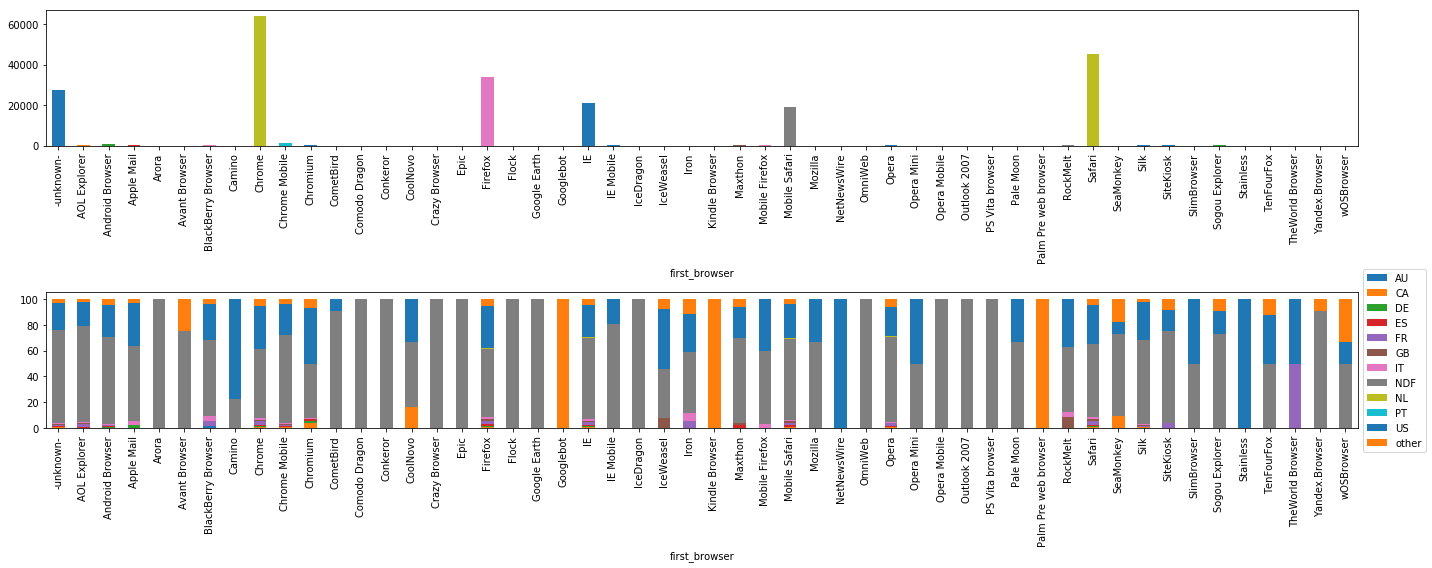

In [40]:
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(211)
data_preprocessed.groupby('first_browser').size().plot(kind='bar', ax=ax1)

ax4 = fig.add_subplot(212)
data_preprocessed.groupby(['first_browser', 'country_destination']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax4)
ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

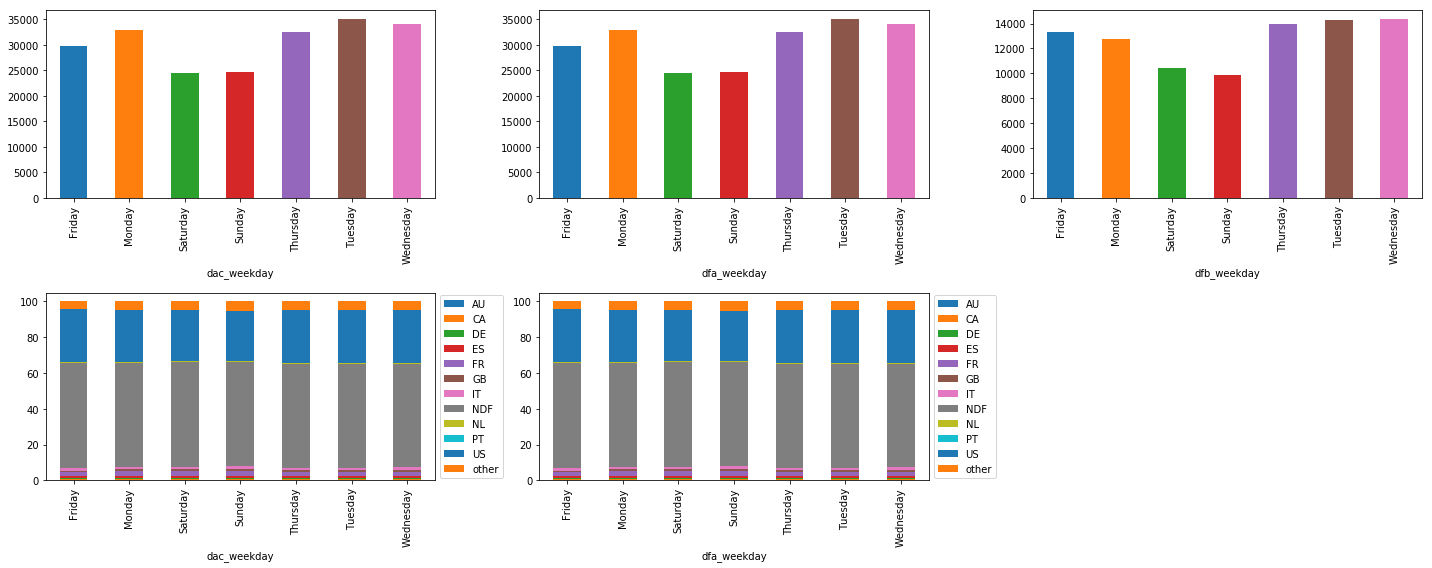

In [41]:
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(231)
data_preprocessed.groupby('dac_weekday').size().plot(kind='bar', ax=ax1)

ax2 = fig.add_subplot(232)
data_preprocessed.groupby('dfa_weekday').size().plot(kind='bar', ax=ax2)

ax3 = fig.add_subplot(233)
data_preprocessed.groupby('dfb_weekday').size().plot(kind='bar', ax=ax3)

ax4 = fig.add_subplot(234)
data_preprocessed.groupby(['dac_weekday', 'country_destination']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax4)
ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax5 = fig.add_subplot(235)
data_preprocessed.groupby(['dfa_weekday', 'country_destination']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax5)
ax5.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

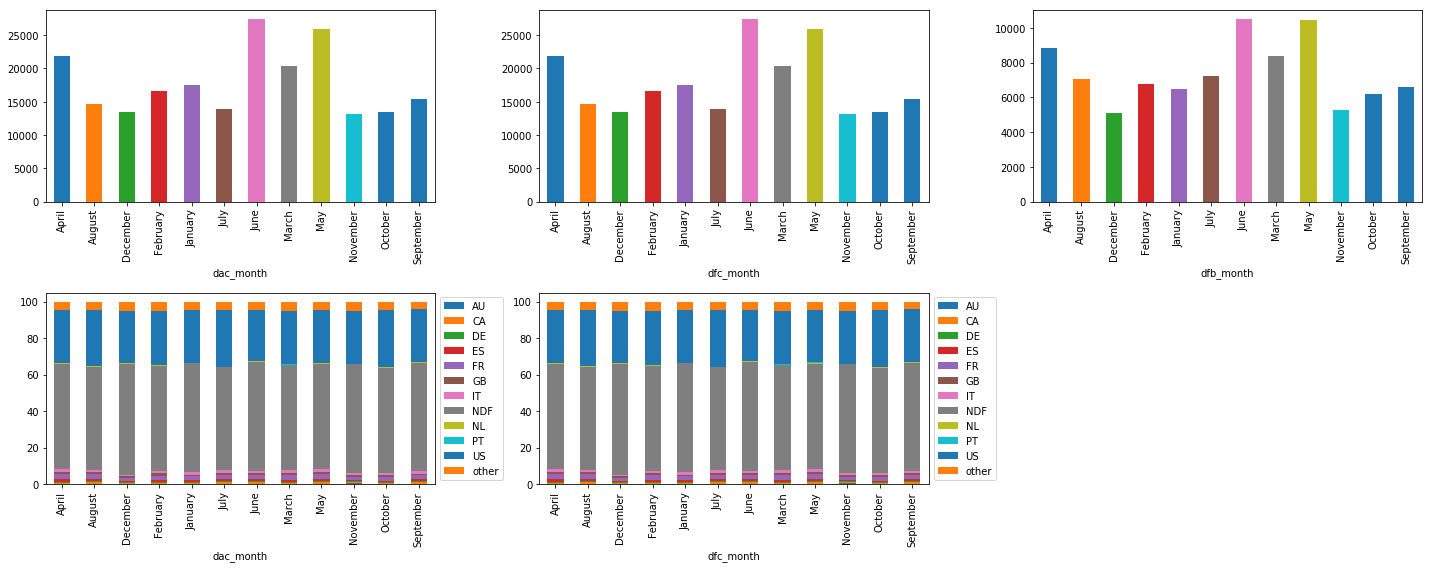

In [42]:
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(231)
data_preprocessed.groupby('dac_month').size().plot(kind='bar', ax=ax1)

ax2 = fig.add_subplot(232)
data_preprocessed.groupby('dfc_month').size().plot(kind='bar', ax=ax2)

ax3 = fig.add_subplot(233)
data_preprocessed.groupby('dfb_month').size().plot(kind='bar', ax=ax3)

ax4 = fig.add_subplot(234)
data_preprocessed.groupby(['dac_month', 'country_destination']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax4)
ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax5 = fig.add_subplot(235)
data_preprocessed.groupby(['dfc_month', 'country_destination']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax5)
ax5.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

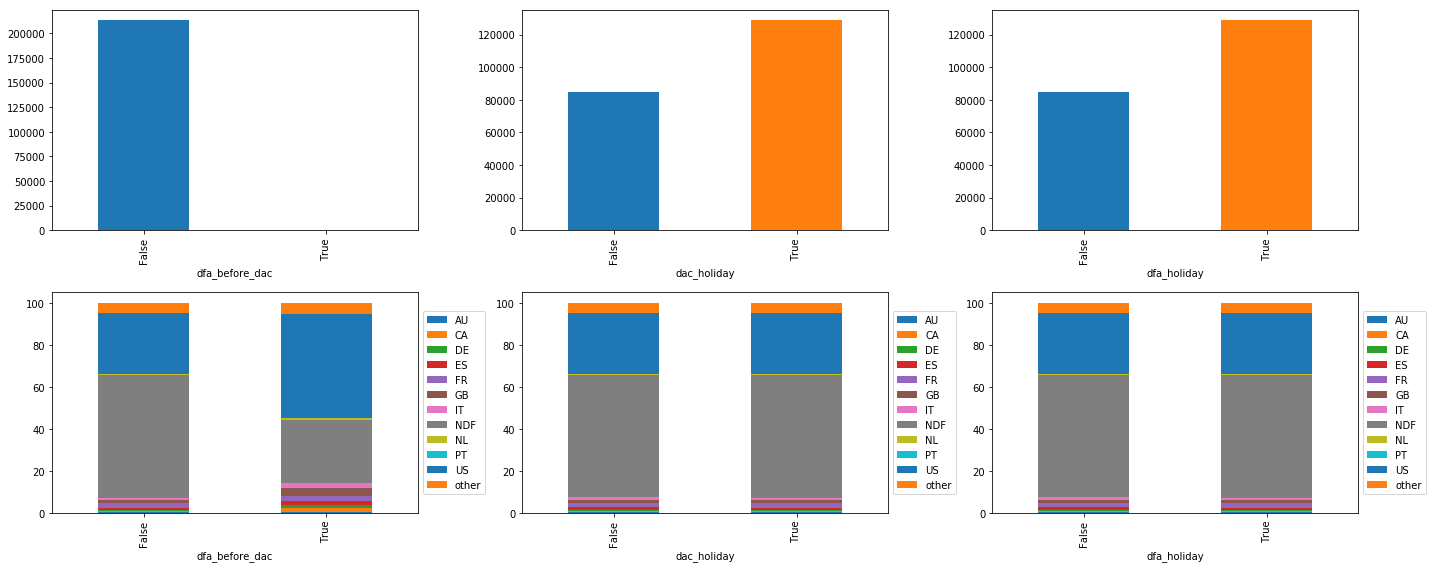

In [43]:
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(231)
data_preprocessed.groupby('dfa_before_dac').size().plot(kind='bar', ax=ax1)

ax2 = fig.add_subplot(232)
data_preprocessed.groupby('dac_holiday').size().plot(kind='bar', ax=ax2)

ax3 = fig.add_subplot(233)
data_preprocessed.groupby('dfa_holiday').size().plot(kind='bar', ax=ax3)

ax4 = fig.add_subplot(234)
data_preprocessed.groupby(['dfa_before_dac', 'country_destination']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax4)
ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax5 = fig.add_subplot(235)
data_preprocessed.groupby(['dac_holiday', 'country_destination']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax5)
ax5.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax6 = fig.add_subplot(236)
data_preprocessed.groupby(['dfa_holiday', 'country_destination']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar', stacked=True, ax=ax6)
ax6.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

### Time Series

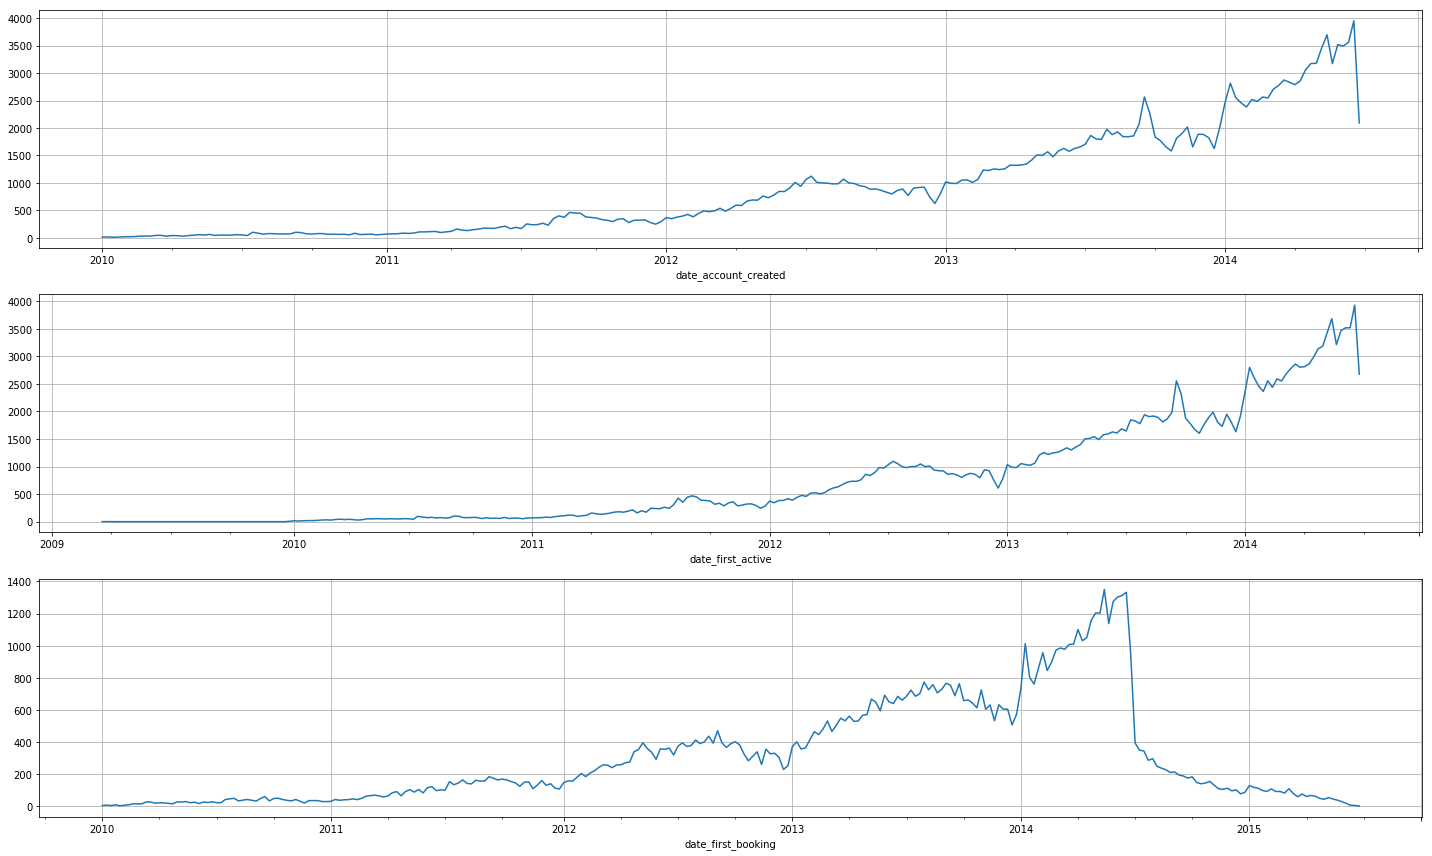

In [44]:
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(311)
data_preprocessed[['date_account_created']].set_index('date_account_created').resample('7D').size().plot(ax=ax1)
ax1.grid()

ax2 = fig.add_subplot(312)
data_preprocessed[['date_first_active']].set_index('date_first_active').resample('7D').size().plot(ax=ax2)
ax2.grid()

ax3 = fig.add_subplot(313)
data_preprocessed[['date_first_booking']].set_index('date_first_booking').resample('7D').size().plot(ax=ax3)
ax3.grid()

plt.tight_layout()
plt.show()

## Model Fitting

What is next?